<a href="https://colab.research.google.com/github/killercookiee/DeepM/blob/main/DeepM_main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!git clone https://github.com/AMIN-HASSAIRI/medical-image-segmentation.git

fatal: destination path 'medical-image-segmentation' already exists and is not an empty directory.


Understanding the File format

Neuroimaging Informatics Technology Initiative
NIfTI is designed to handle 3D (volume) and 4D (time-series) data, which is common in brain imaging, especially for functional MRI (fMRI) studies
NIfTI files can also be stored in a compressed .nii.gz format to save disk space

4 D --> Height + Width + Depth + Time

We are working with pairs of files. Example
1. Say MRI scan of heart
2. Corresponding segmentation mask file -> i.e. a label that marks different part of the image, like heart chambers, valves, etc

Possibly

patient001_4d.nii.gz -> 4D file (Sequence of 3d images over time), not used for segmentation
patient001_frame01.nii.gz -> A single 2D slice of the 3D MRI data. Image file used for traning the model
patient001_frame01_gt.nii.gz -> It contains labels marking the regions of interest in the image

# Imports

In [1]:
%pip install opencv-python --quiet
%pip install scikit-image --quiet

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [141]:
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from skimage.transform import resize
import cv2

import shutil

# Original Training Data

In [142]:
def select_training_data(dataset_dir):
    data_anomolies = ['038', '085', '057', '089', '100']

    training_data_list = {}
    for k in ['training']:

        subset_dir = os.path.join(dataset_dir, k)
        training_data_list[k] = []

        for patient in sorted(os.listdir(subset_dir)):

            patient_dir = os.path.join(subset_dir, patient)

            # Skip files that are not directories
            if not os.path.isdir(patient_dir):
                continue

            for file in sorted(os.listdir(patient_dir)):
                if file[-8] == 't' and file[-21:-18] not in data_anomolies:

                    image_name = '{0}/{1}_frame{2}.nii.gz'.format(patient_dir, patient, file[-12:-10])
                    segt_name = '{0}/{1}_frame{2}_gt.nii.gz'.format(patient_dir, patient, file[-12:-10])

                    if os.path.exists(image_name) and os.path.exists(segt_name):
                        training_data_list[k] += [[image_name, segt_name, patient]]

    return training_data_list



In [143]:
original_training_data_list = select_training_data("/Users/killercookie/Main file/DeepM/medical-image-segmentation/dataset")

In [144]:
original_training_data_list

{'training': [['/Users/killercookie/Main file/DeepM/medical-image-segmentation/dataset/training/patient001/patient001_frame01.nii.gz',
   '/Users/killercookie/Main file/DeepM/medical-image-segmentation/dataset/training/patient001/patient001_frame01_gt.nii.gz',
   'patient001'],
  ['/Users/killercookie/Main file/DeepM/medical-image-segmentation/dataset/training/patient001/patient001_frame12.nii.gz',
   '/Users/killercookie/Main file/DeepM/medical-image-segmentation/dataset/training/patient001/patient001_frame12_gt.nii.gz',
   'patient001'],
  ['/Users/killercookie/Main file/DeepM/medical-image-segmentation/dataset/training/patient002/patient002_frame01.nii.gz',
   '/Users/killercookie/Main file/DeepM/medical-image-segmentation/dataset/training/patient002/patient002_frame01_gt.nii.gz',
   'patient002'],
  ['/Users/killercookie/Main file/DeepM/medical-image-segmentation/dataset/training/patient002/patient002_frame12.nii.gz',
   '/Users/killercookie/Main file/DeepM/medical-image-segmentati

In [145]:
def select_testing_data(dataset_dir):
    testing_data_list = {}
    
    for k in ['testing']:
        subset_dir = os.path.join(dataset_dir, k)
        testing_data_list[k] = []

        for patient in sorted(os.listdir(subset_dir)):

            patient_dir = os.path.join(subset_dir, patient)

            # Skip files that are not directories
            if not os.path.isdir(patient_dir):
                continue

            for file in sorted(os.listdir(patient_dir)):
                if file[-8] != 'd' and file[-8] != 'I':

                    image_name = '{0}/{1}_frame{2}.nii.gz'.format(patient_dir, patient, file[-12:-10])
                    segt_name = '{0}/{1}_frame{2}_gt.nii.gz'.format(patient_dir, patient, file[-12:-10])

                    if os.path.exists(image_name) and os.path.exists(segt_name):
                        testing_data_list[k] += [[image_name, segt_name, patient]]

    return testing_data_list


In [146]:
original_testing_data_list = select_testing_data("/Users/killercookie/Main file/DeepM/medical-image-segmentation/dataset")

In [147]:
original_testing_data_list

{'testing': [['/Users/killercookie/Main file/DeepM/medical-image-segmentation/dataset/testing/patient101/patient101_frame01.nii.gz',
   '/Users/killercookie/Main file/DeepM/medical-image-segmentation/dataset/testing/patient101/patient101_frame01_gt.nii.gz',
   'patient101'],
  ['/Users/killercookie/Main file/DeepM/medical-image-segmentation/dataset/testing/patient101/patient101_frame14.nii.gz',
   '/Users/killercookie/Main file/DeepM/medical-image-segmentation/dataset/testing/patient101/patient101_frame14_gt.nii.gz',
   'patient101'],
  ['/Users/killercookie/Main file/DeepM/medical-image-segmentation/dataset/testing/patient102/patient102_frame01.nii.gz',
   '/Users/killercookie/Main file/DeepM/medical-image-segmentation/dataset/testing/patient102/patient102_frame01_gt.nii.gz',
   'patient102'],
  ['/Users/killercookie/Main file/DeepM/medical-image-segmentation/dataset/testing/patient102/patient102_frame13.nii.gz',
   '/Users/killercookie/Main file/DeepM/medical-image-segmentation/datas

# Image Analysis

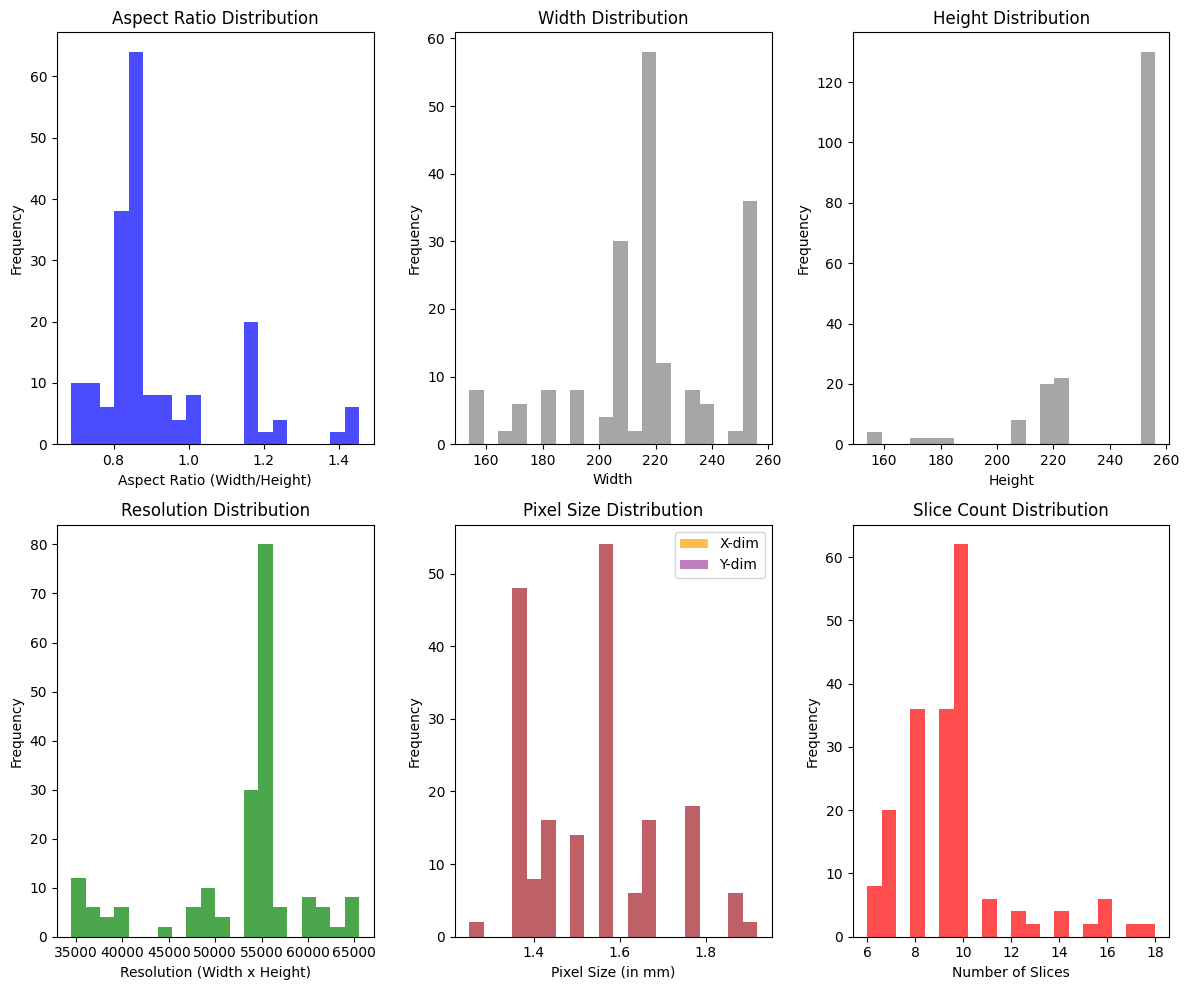

In [148]:
# Analyzing the data

def analyze_image_properties(training_data_list):
    aspect_ratios = []
    widths = []
    heights = []
    resolutions = []
    pixel_sizes = []
    slice_counts = []
    
    # Loop through each file in training_data_list (ignoring the segmentation files)
    for data in training_data_list['training']:
        image_file = data[0]  # Use the image file, not the segmentation file
        
        # Load the NIfTI file
        img = nib.load(image_file)
        img_data = img.get_fdata()
        img_shape = img_data.shape
        
        # Analyze shape and pixel sizes
        if len(img_shape) >= 2:
            width = img_shape[0]
            height = img_shape[1]
            depth = img_shape[2] if len(img_shape) > 2 else 1  # Number of slices or depth
            
            # Aspect ratio (width to height)
            aspect_ratio = width / height
            aspect_ratios.append(aspect_ratio)
            
            # Resolution (total number of pixels in 2D)
            resolution = width * height
            resolutions.append(resolution)

            # Widths and heights
            widths.append(width)
            heights.append(height)
            
            # Slice count (for 3D images)
            slice_counts.append(depth)
        
        # Voxel size (physical dimensions of each voxel)
        voxel_size = img.header.get_zooms()  # Tuple (x_size, y_size, z_size)
        pixel_sizes.append(voxel_size)
    
    return aspect_ratios, widths, heights, resolutions, pixel_sizes, slice_counts


# Analyze the training data
aspect_ratios, widths, heights, resolutions, pixel_sizes, slice_counts = analyze_image_properties(original_training_data_list)

# Plot the results
def plot_analysis(aspect_ratios, widths, heights, resolutions, pixel_sizes, slice_counts):
    fig, ax = plt.subplots(2, 3, figsize=(12, 10))
    
    # Aspect Ratio
    ax[0, 0].hist(aspect_ratios, bins=20, color='blue', alpha=0.7)
    ax[0, 0].set_title("Aspect Ratio Distribution")
    ax[0, 0].set_xlabel("Aspect Ratio (Width/Height)")
    ax[0, 0].set_ylabel("Frequency")
    
    # Width
    ax[0, 1].hist(widths, bins=20, color='grey', alpha=0.7)
    ax[0, 1].set_title("Width Distribution")
    ax[0, 1].set_xlabel("Width")
    ax[0, 1].set_ylabel("Frequency")

    # Height
    ax[0, 2].hist(heights, bins=20, color='grey', alpha=0.7)
    ax[0, 2].set_title("Height Distribution")
    ax[0, 2].set_xlabel("Height")
    ax[0, 2].set_ylabel("Frequency")

    # Resolution
    ax[1, 0].hist(resolutions, bins=20, color='green', alpha=0.7)
    ax[1, 0].set_title("Resolution Distribution")
    ax[1, 0].set_xlabel("Resolution (Width x Height)")
    ax[1, 0].set_ylabel("Frequency")
    
    # Pixel Size
    pixel_sizes_arr = np.array(pixel_sizes)  # Convert list of tuples to numpy array
    ax[1, 1].hist(pixel_sizes_arr[:, 0], bins=20, color='orange', alpha=0.7, label='X-dim')
    ax[1, 1].hist(pixel_sizes_arr[:, 1], bins=20, color='purple', alpha=0.5, label='Y-dim')
    ax[1, 1].set_title("Pixel Size Distribution")
    ax[1, 1].set_xlabel("Pixel Size (in mm)")
    ax[1, 1].set_ylabel("Frequency")
    ax[1, 1].legend()
    
    # Slice Count (number of slices in the depth dimension)
    ax[1, 2].hist(slice_counts, bins=20, color='red', alpha=0.7)
    ax[1, 2].set_title("Slice Count Distribution")
    ax[1, 2].set_xlabel("Number of Slices")
    ax[1, 2].set_ylabel("Frequency")
    
    plt.tight_layout()
    plt.show()

# Plot the analysis
plot_analysis(aspect_ratios, widths, heights, resolutions, pixel_sizes, slice_counts)

# Data Standardization

In [149]:
def load_nifti_image(nifti_file):
    """Load NIfTI image and return image data."""
    img = nib.load(nifti_file)
    return img.get_fdata()

def normalize_image(img_data):
    """Normalize the image pixel values to [0, 1] range."""
    img_min = np.min(img_data)
    img_max = np.max(img_data)
    return (img_data - img_min) / (img_max - img_min)

def standardize_image(img_data):
    """Standardize the image to have mean=0 and std=1."""
    mean = np.mean(img_data)
    std = np.std(img_data)
    return (img_data - mean) / std

def pad_to_aspect_ratio(img_data, target_aspect_ratio, padding_value=0):
    """Pad image to match the target aspect ratio."""
    h, w = img_data.shape[:2]
    current_aspect_ratio = w / h
    if current_aspect_ratio == target_aspect_ratio:
        return img_data  # No padding needed

    if current_aspect_ratio < target_aspect_ratio:
        # Pad width
        new_width = int(h * target_aspect_ratio)
        pad_left = (new_width - w) // 2
        img_data = np.pad(img_data, ((0, 0), (pad_left, new_width - w - pad_left)),
                          constant_values=padding_value)
    else:
        # Pad height
        new_height = int(w / target_aspect_ratio)
        pad_top = (new_height - h) // 2
        img_data = np.pad(img_data, ((pad_top, new_height - h - pad_top), (0, 0)),
                          constant_values=padding_value)
    
    return img_data

def resize_image(img_data, target_size=(256, 256)):
    """Resize the image to the target size."""
    from skimage.transform import resize
    return resize(img_data, target_size, anti_aliasing=True, preserve_range=True)




def combine_slices_into_nifti(img_file, seg_file, save_folder, frame_label):
    """Combine image and segmentation slices into a single 3D NIfTI volume."""
    
    # Load image and segmentation data
    img_data = nib.load(img_file).get_fdata()
    seg_data = nib.load(seg_file).get_fdata()
    
    # Ensure they have the same dimensions
    if img_data.shape != seg_data.shape:
        raise ValueError(f"Image and segmentation dimensions do not match for {img_file}.")
    
    # Create NIfTI image object
    affine = nib.load(img_file).affine  # Re-use affine from original NIfTI file
    combined_nifti = nib.Nifti1Image(img_data, affine)
    combined_seg_nifti = nib.Nifti1Image(seg_data, affine)
    
    # Save combined 3D NIfTI image
    patient_id = os.path.basename(img_file).split('_')[0]  # Extract patient ID from filename
    output_image_file = os.path.join(save_folder, f'{patient_id}_{frame_label}.nii.gz')
    output_seg_file = os.path.join(save_folder, f'{patient_id}_{frame_label}_gt.nii.gz')
    
    nib.save(combined_nifti, output_image_file)
    nib.save(combined_seg_nifti, output_seg_file)

def get_second_frame(patient_data):
    """Identify the second frame that is not frame01."""
    for frame in patient_data:
        if "frame01" not in frame[0]:
            return frame
    return None  # In case no second frame is found

def process_patient_data(patient_frames, save_dir):
    """Process and transform the patient data for both frames."""
    img_file_1, seg_file_1, patient_id = patient_frames[0]  # Frame01
    second_frame = get_second_frame(patient_frames)  # Identify the second frame

    if second_frame:
        img_file_2, seg_file_2, _ = second_frame  # The second frame

        # Create patient folder
        patient_folder = os.path.join(save_dir, patient_id)
        os.makedirs(patient_folder, exist_ok=True)

        # Transform both frames and their corresponding segmentation files
        combine_slices_into_nifti(img_file_1, seg_file_1, patient_folder, "frame01")  # Frame01
        combine_slices_into_nifti(img_file_2, seg_file_2, patient_folder, "frame02")  # Second Frame

def create_new_training_dataset(training_data_list, save_dir):
    """Create a new dataset by transforming and combining patient slices."""
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    # Group data by patient
    patient_dict = {}
    for img_file, seg_file, patient_id in training_data_list['training']:
        if patient_id not in patient_dict:
            patient_dict[patient_id] = []
        patient_dict[patient_id].append((img_file, seg_file, patient_id))
    
    # Process each patient
    for patient_data in patient_dict.values():
        process_patient_data(patient_data, save_dir)

def create_new_testing_dataset(testing_data_list, save_dir):
    """Create a new dataset by transforming and combining patient slices."""
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    # Group data by patient
    patient_dict = {}
    for img_file, seg_file, patient_id in testing_data_list['testing']:
        if patient_id not in patient_dict:
            patient_dict[patient_id] = []
        patient_dict[patient_id].append((img_file, seg_file, patient_id))
    
    # Process each patient
    for patient_data in patient_dict.values():
        process_patient_data(patient_data, save_dir)


# Example usage
training_save_dir = './medical-image-segmentation/new_dataset/training'
create_new_training_dataset(original_training_data_list, training_save_dir)

testing_save_dir = './medical-image-segmentation/new_dataset/testing'
create_new_testing_dataset(original_testing_data_list, testing_save_dir)

# New Standardized Dataset

In [150]:
def select_new_training_data(dataset_dir):
    data_anomolies = ['038', '085', '057', '089', '100']

    training_data_list = {}
    for k in ['training']:

        subset_dir = os.path.join(dataset_dir, k)
        training_data_list[k] = []

        for patient in sorted(os.listdir(subset_dir)):

            patient_dir = os.path.join(subset_dir, patient)

            # Skip files that are not directories
            if not os.path.isdir(patient_dir):
                continue

            for file in sorted(os.listdir(patient_dir)):
                if file[-8] == 't' and file[-21:-18] not in data_anomolies:

                    image_name = '{0}/{1}_frame{2}.nii.gz'.format(patient_dir, patient, file[-12:-10])
                    segt_name = '{0}/{1}_frame{2}_gt.nii.gz'.format(patient_dir, patient, file[-12:-10])

                    if os.path.exists(image_name) and os.path.exists(segt_name):
                        training_data_list[k] += [[image_name, segt_name, patient]]

    return training_data_list



def select_new_testing_data(dataset_dir):
    testing_data_list = {}
    
    for k in ['testing']:
        subset_dir = os.path.join(dataset_dir, k)
        testing_data_list[k] = []

        for patient in sorted(os.listdir(subset_dir)):

            patient_dir = os.path.join(subset_dir, patient)

            # Skip files that are not directories
            if not os.path.isdir(patient_dir):
                continue

            for file in sorted(os.listdir(patient_dir)):
                if file[-8] != 'd' and file[-8] != 'I':

                    image_name = '{0}/{1}_frame{2}.nii.gz'.format(patient_dir, patient, file[-12:-10])
                    segt_name = '{0}/{1}_frame{2}_gt.nii.gz'.format(patient_dir, patient, file[-12:-10])

                    if os.path.exists(image_name) and os.path.exists(segt_name):
                        testing_data_list[k] += [[image_name, segt_name, patient]]
    
    return testing_data_list



training_data_list = select_new_training_data("/Users/killercookie/Main file/DeepM/medical-image-segmentation/new_dataset")
testing_data_list = select_new_testing_data("/Users/killercookie/Main file/DeepM/medical-image-segmentation/new_dataset")

In [151]:
training_data_list

{'training': [['/Users/killercookie/Main file/DeepM/medical-image-segmentation/new_dataset/training/patient001/patient001_frame01.nii.gz',
   '/Users/killercookie/Main file/DeepM/medical-image-segmentation/new_dataset/training/patient001/patient001_frame01_gt.nii.gz',
   'patient001'],
  ['/Users/killercookie/Main file/DeepM/medical-image-segmentation/new_dataset/training/patient001/patient001_frame02.nii.gz',
   '/Users/killercookie/Main file/DeepM/medical-image-segmentation/new_dataset/training/patient001/patient001_frame02_gt.nii.gz',
   'patient001'],
  ['/Users/killercookie/Main file/DeepM/medical-image-segmentation/new_dataset/training/patient002/patient002_frame01.nii.gz',
   '/Users/killercookie/Main file/DeepM/medical-image-segmentation/new_dataset/training/patient002/patient002_frame01_gt.nii.gz',
   'patient002'],
  ['/Users/killercookie/Main file/DeepM/medical-image-segmentation/new_dataset/training/patient002/patient002_frame02.nii.gz',
   '/Users/killercookie/Main file/De

# Data Visualization

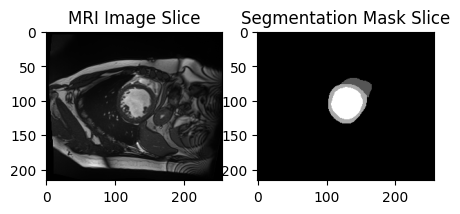

In [152]:
## Visualising .nii.gz files using nibabel library ---- used for reading neuroimaging data

## Sample Example
example_data = training_data_list['training'][0]  # Get the first entry
image_path = example_data[0]  # Path to the image
mask_path = example_data[1]  # Path to the segmentation mask



def load_nifti_image(nifti_file):
    # Load the image using nibabel
    img = nib.load(nifti_file)
    img_data = img.get_fdata()  # Getting the actual image data as a numpy array
    return img_data

def visualize_image_and_mask(image_file, mask_file):
    # Load image and mask
    img_data = load_nifti_image(image_file)
    mask_data = load_nifti_image(mask_file)

    # Let's visualize a slice in the middle
    slice_num = img_data.shape[2] // 2
    fig, ax = plt.subplots(1, 2, figsize=(5, 3))

    # Display MRI image slice
    ax[0].imshow(img_data[:, :, slice_num], cmap='gray')
    ax[0].set_title("MRI Image Slice")

    # Display Segmentation Mask slice
    ax[1].imshow(mask_data[:, :, slice_num], cmap='gray')
    ax[1].set_title("Segmentation Mask Slice")

    plt.show()

# Random examples visualisation

visualize_image_and_mask(training_data_list['training'][0][0], training_data_list['training'][0][1])
# visualize_image_and_mask(training_data_list['training'][50][0], training_data_list['training'][50][1])
